In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('train.tsv', sep='\t')

# General informations about the dataset

Index(['category', 'headline', 'text', 'url'], dtype='object')
category
sports        350
business      350
politics      350
health        350
technology     76
Name: count, dtype: int64
   category                                           headline  \
0    sports         L'Ouganda à l'assaut des "fimbu" de la RDC   
1  business  Stopper la détérioration de l’environnement po...   
2    sports  Coupe d'Afrique des nations 2022 : le sélectio...   
3  business  Tissus africains : pourquoi les teintureries h...   
4  business  Les revenus pendant la pandémie des dix hommes...   

                                                text  \
0  L'Ouganda, placé 79e au classement FIFA le 4 a...   
1  La responsable de la biodiversité des Nations ...   
2  Le sélectionneur de la Sierra Leone, John Keis...   
3  Depuis plus de six siècles, une vaste zone sit...   
4  Pendant la pandémie de coronavirus, la richess...   

                                                 url  
0        https://www.bb

<Axes: xlabel='category'>

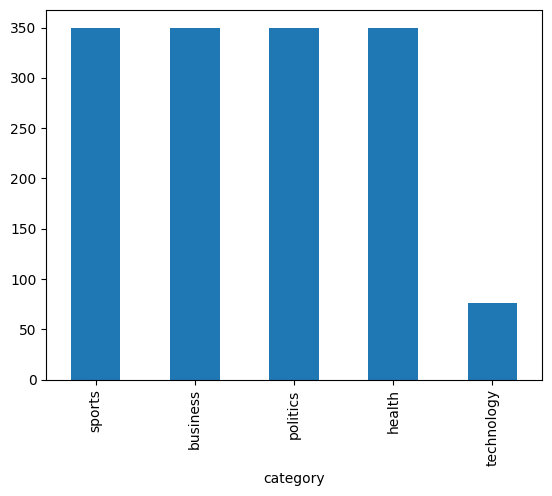

In [2]:
print(df.keys())
print(df['category'].value_counts())
print(df.head())

# show the distribution of the categories
df['category'].value_counts().plot(kind='bar')

In [3]:
# Balancing the dataset
import random

# Multiply by 4 each line of tech category
aug_df = df.copy()
for i in range(4):
    tech = df[df['category'] == 'technology']
    aug_df = pd.concat([aug_df, tech], ignore_index=True)

# sports        350
# business      350
# politics      350
# health        350
# technology    380

# remove 30 random lines in tech category
for i in range(30):
    aug_df = aug_df.drop(random.choice(
        aug_df[aug_df['category'] == 'technology'].index))

In [4]:
print(aug_df.keys())
print(aug_df['category'].value_counts())
print(aug_df.head())

Index(['category', 'headline', 'text', 'url'], dtype='object')
category
sports        350
business      350
politics      350
health        350
technology    350
Name: count, dtype: int64
   category                                           headline  \
0    sports         L'Ouganda à l'assaut des "fimbu" de la RDC   
1  business  Stopper la détérioration de l’environnement po...   
2    sports  Coupe d'Afrique des nations 2022 : le sélectio...   
3  business  Tissus africains : pourquoi les teintureries h...   
4  business  Les revenus pendant la pandémie des dix hommes...   

                                                text  \
0  L'Ouganda, placé 79e au classement FIFA le 4 a...   
1  La responsable de la biodiversité des Nations ...   
2  Le sélectionneur de la Sierra Leone, John Keis...   
3  Depuis plus de six siècles, une vaste zone sit...   
4  Pendant la pandémie de coronavirus, la richess...   

                                                 url  
0        https://www.bb

## Let's see how the length of the headlines and texts are distributed

array([[<Axes: title={'center': 'business'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'politics'}>,
        <Axes: title={'center': 'sports'}>],
       [<Axes: title={'center': 'technology'}>, <Axes: >]], dtype=object)

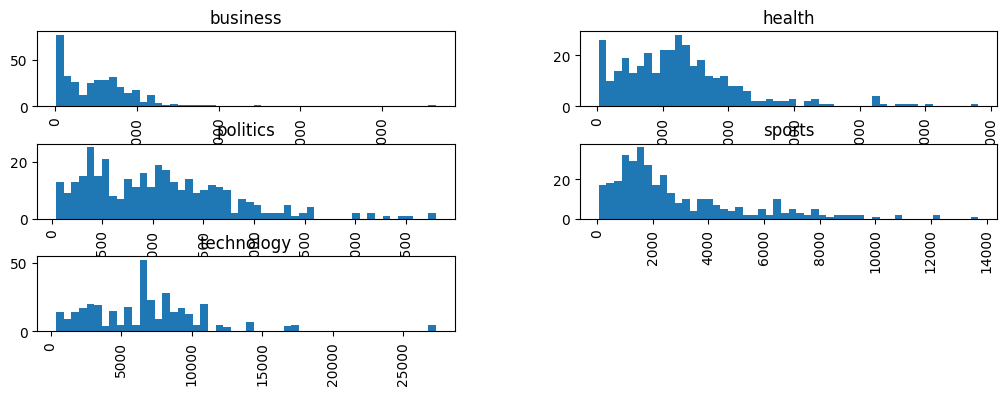

In [5]:
c = "technology"

# plot the length of the headlines for each category
aug_df['length'] = aug_df['text'].apply(len)
aug_df.hist(column='length', by='category', bins=50, figsize=(12, 4))


<Axes: ylabel='Frequency'>

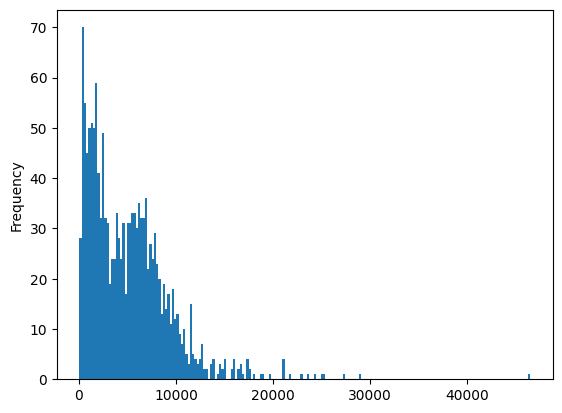

In [6]:
df["text"].apply(len).plot.hist(bins=200)

### Findings
- Url not relevant, we can drop this column
- Technology is clearly underrepresented in the dataset (1/5 of the support of other categories)
- texts lengths are in the range 0-10_000 characters, very small minority goes up to 40_000 chars.

We will need to take those informations into account to train the best model possible.

# Vectorizing

In [7]:
df_test = pd.read_csv('test.tsv', sep='\t')

# show count of each category
print(df_test['category'].value_counts())

X_test = df_test[['headline', 'text']]
y_test = df_test["category"]

category
business      100
health        100
politics      100
sports        100
technology     22
Name: count, dtype: int64


In [8]:
X = df[['headline', 'text']]
y = df["category"]

X_train, y_train = X, y

In [68]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

SnowballStemmer = nltk.stem.SnowballStemmer

nltk.download("stopwords")
nltk.download('punkt')
stemmer = SnowballStemmer("french")

french_stopwords = stopwords.words(
    'french') + list(string.punctuation) + ["''", '``', '...', '’', '``', '«', '»', '``']


def tokenize(text):
    tokens = word_tokenize(text, language='french')
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    # stemming
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens


vectorizer = TfidfVectorizer(tokenizer=tokenize,
                             stop_words=french_stopwords,
                             max_features=1200,
                             lowercase=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spoto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spoto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
tokenize("Ceci est un test de tokenization")

['cec', 'est', 'un', 'test', 'de', 'tokeniz']

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

col_trans = ColumnTransformer(
    [('headline', vectorizer, 'headline'),
        ('text', vectorizer, 'text')
    ])

pipe = make_pipeline(col_trans, LogisticRegression(class_weight='balanced'))

In [71]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('headline',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=1200,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                              'en',
                                                                              'et',
                                                                              'eux',
                                                                              'il',
                                                                              'ils',
                                                                              'je',
                                                                              'la',
                                                                              'le',
                                                                              'les',
                                                                              'leur',
                                                                              'lui',
                                                                              'ma',
                                                                              'mais',
                                                                              'me',
                                                                              'même',
                                                                              'mes',
                                                                              'moi',
                                                                              'mon',
                                                                              'ne',
                                                                              'nos', ...],
                                                                  tokenizer=<function tokenize at...
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=1200,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                 

In [72]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.75      0.83      0.79       100
      health       0.91      0.92      0.92       100
    politics       0.86      0.84      0.85       100
      sports       0.96      0.93      0.94       100
  technology       0.87      0.59      0.70        22

    accuracy                           0.86       422
   macro avg       0.87      0.82      0.84       422
weighted avg       0.87      0.86      0.86       422



In [62]:
# Compute accuracy by hand using the 2 top predictions
y_pred_proba = pipe.predict_proba(X_test)
acc = 0
classes = pipe.classes_
for i, pred in enumerate(y_pred_proba):
    top_2 = pred.argsort()[-2:][::-1]
    top_2_classes = [classes[i] for i in top_2]
    actual = y_test.iloc[i]
    print(f"Top 2 classes : {top_2_classes}, actual : {actual}")
    if actual in top_2_classes:
        acc += 1
print(f"Accuracy : {acc/len(y_pred_proba)}")

Top 2 classes : ['sports', 'business'], actual : business
Top 2 classes : ['business', 'technology'], actual : business
Top 2 classes : ['business', 'politics'], actual : business
Top 2 classes : ['business', 'health'], actual : business
Top 2 classes : ['politics', 'business'], actual : business
Top 2 classes : ['business', 'technology'], actual : business
Top 2 classes : ['business', 'politics'], actual : business
Top 2 classes : ['health', 'business'], actual : business
Top 2 classes : ['business', 'technology'], actual : business
Top 2 classes : ['business', 'politics'], actual : business
Top 2 classes : ['politics', 'business'], actual : business
Top 2 classes : ['business', 'politics'], actual : business
Top 2 classes : ['business', 'health'], actual : business
Top 2 classes : ['business', 'politics'], actual : business
Top 2 classes : ['business', 'politics'], actual : business
Top 2 classes : ['business', 'technology'], actual : business
Top 2 classes : ['politics', 'business']

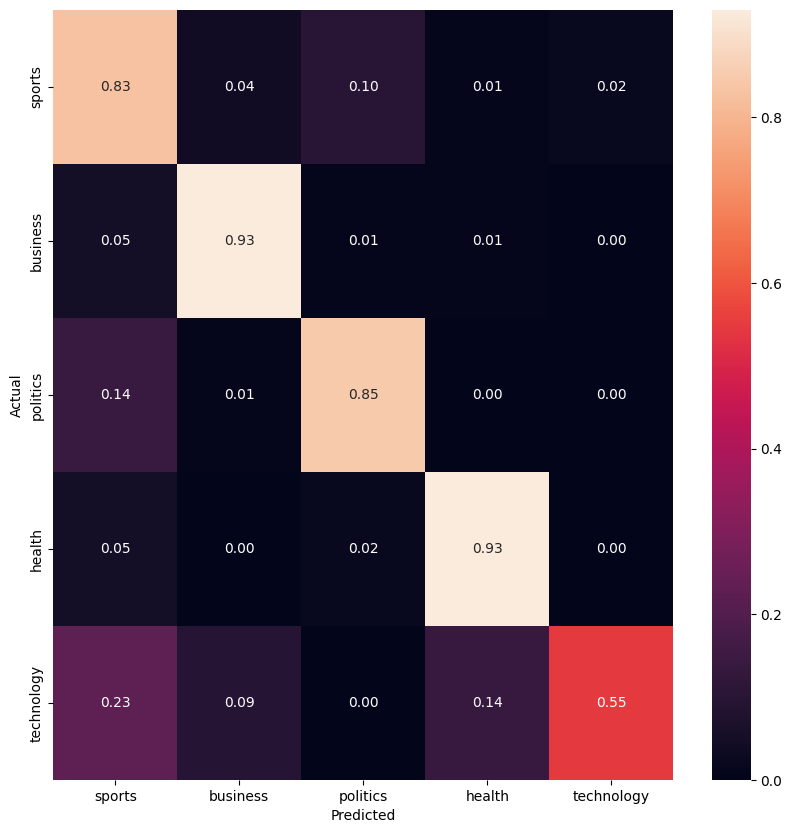

In [57]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='.2f',
            xticklabels=df['category'].unique(), yticklabels=df['category'].unique())

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Learning from our mistakes

In [15]:
# Show wrong predictions
df_test['predicted_category'] = y_pred
df_test['correct'] = df_test['category'] == df_test['predicted_category']
df_test[(df_test['correct'] == False) & (df_test['category'] == "business") & (df_test['url'].str.contains("60638785"))]

,category,headline,text,url,predicted_category,correct
16,business,Guerre Ukraine - Russie : qui sont les oligarq...,"Les gouvernements britannique, européen et amé...",https://www.bbc.com/afrique/monde-60638785,politics,False


Let's see what type of model is better

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Multinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier())
]

for name, model in models:
    pipe = make_pipeline(col_trans, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'{name}: {accuracy_score(y_test, y_pred)}')

Baseline: 0.23696682464454977


KeyboardInterrupt: 